In [1]:
from kafka import KafkaConsumer
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


In [2]:
# Create a Kafka consumer instance
# Consumer subscribes to the 'ml-raw-dns' topic and connects to Kafka broker running on 'localhost:9092'
# 'auto_offset_reset' is set to 'earliest' to start consuming from the earliest available offset
# 'enable_auto_commit' is set to False, meaning manual offset committing will be used
consumer = KafkaConsumer(
    'ml-raw-dns',  # Subscribe to the 'ml-raw-dns' topic
    bootstrap_servers="localhost:9092",  # Kafka broker's address
    auto_offset_reset='earliest',  # Start consuming from the earliest available offset
    enable_auto_commit=False  # Manual offset committing
)


6)Get_Record, aims to retrieve 1000 records from a Kafka consumer and store them in a list. Here's a brief explanation of the function:


In [3]:
def Get_Record(itr):
    list_of_1000_rec = []  # Initialize an empty list to store 1000 records
    i = 0  # Initialize a counter to keep track of the number of records retrieved
    for c in consumer:  # Iterate over messages from the Kafka consumer

        if i < 1000:  # Check if fewer than 1000 records have been retrieved
            list_of_1000_rec.append(c.value)  # Append the value of the Kafka message to the list
            i += 1  # Increment the counter
        else:
            break  # Break the loop when 1000 records have been retrieved

    print(f"Window {itr}")  # Print the window number (iteration count)

    return list_of_1000_rec  # Return the list containing 1000 records


All Features

In [4]:
columns_list = 'timestamp', 'FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric', 'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'longest_word', 'sld', 'len', 'subdomain', 'Target Attack'

Best 8 Features based on Mutual Information Scores:

In [5]:
features =['FQDN_count','entropy','labels','labels_average','longest_word','lower','sld','special']


This Data_Adjust function seems to be designed to process a list of items (presumably rows of a dataset) and convert them into a pandas DataFrame

In [6]:
def Data_Adjust(data):
    # Create an empty DataFrame
    dataframe = pd.DataFrame()
    list_of_rows = []

    # Loop through each item in the data list
    for item in data:
        # Convert the item from bytes to a string and remove leading/trailing whitespace
        row_string = eval(item.decode("UTF-8"))
        row_string = row_string.strip()
        
        # Split the string into a list using comma as the delimiter
        row = row_string.split(",")

        # Append the resulting list (representing a row) to a list of rows
        list_of_rows.append(row)

    # Create a DataFrame from the list of rows
    dataframe = pd.DataFrame(list_of_rows)

    # Assign column names to the DataFrame using the provided 'columns_list'
    dataframe.columns = columns_list

    return dataframe



The Data_Clean function appears to perform several data cleaning and preprocessing steps on the input dataset.

In [7]:
def Data_Clean(data):
    # Remove rows with missing values (NaNs) and duplicate rows
    data.dropna(inplace=True)
    data.drop_duplicates(inplace=True)
    
    # Drop the 'timestamp' column from the dataset
    data = data.drop(columns=['timestamp'])

    # Find the most frequent values (modes) for 'longest_word' and 'sld' columns
    longest_word_mode_str = data["longest_word"].mode()[0]
    sld_mode_v = int(data["sld"].mode()[0])

    # Create dictionaries to map unique categorical values to numerical indices
    longest_word_embedding = {value: i for i, value in enumerate(data['longest_word'].unique())}
    sld_embedding = {value: i for i, value in enumerate(data['sld'].unique())}

    # Replace original categorical values in 'longest_word' and 'sld' columns with numerical indices
    data['longest_word'] = data['longest_word'].apply(lambda x: longest_word_embedding.get(x, longest_word_mode_str))
    data['sld'] = data['sld'].apply(lambda x: sld_embedding.get(x, sld_mode_v)).astype(int)
    
    # Convert the entire dataframe to float type
    return data.astype('float')



'retrain(data)' function seems to define a pipeline for retraining a machine learning model based on the provided data.

In [8]:
def Retrain(data):
    # Define a Pipeline with feature selection using Mutual Information and a RandomForestClassifier
    pipe = Pipeline(steps=[
        ("Mutual Information with Random Forest Model", SelectKBest(score_func=mutual_info_classif, k=8)),
        ("RandomForestClassifier", RandomForestClassifier())
    ])
    
    # Separate the features (X) and the target variable (y) from the provided 'data'
    X = data.drop(labels=["Target Attack"], axis=1)
    y = data["Target Attack"]
    
    # Fit the pipeline on the data
    pipe.fit(X, y)
    
    # Return the trained pipeline (model)
    return pipe


In [10]:
# Load a saved machine learning model from a file using pickle
loaded_model = pickle.load(open('StaticModel_Mutual_Info_rf_model.pkl', 'rb'))

In [11]:
# Load a machine learning model from a pickle file and assign it to 'static_model' and 'Dynamic_model' variables
static_model = Dynamic_model = pickle.load(open('StaticModel_Mutual_Info_rf_model.pkl', 'rb'))

In [14]:
# Load the initial training data
training_data = Data_Adjust(Get_Record(0))
training_data = Data_Clean(training_data)

Window 0


In [15]:
training_data

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,25.0,8.0,0.0,10.0,9.0,2.556642,6.0,6.0,7.0,3.333333,0.0,0.0,12.0,1.0,0.0
1,25.0,8.0,0.0,10.0,9.0,2.556642,6.0,6.0,7.0,3.333333,0.0,0.0,12.0,1.0,1.0
2,7.0,0.0,0.0,4.0,2.0,1.857542,1.0,2.0,4.0,3.000000,1.0,1.0,5.0,0.0,0.0
3,12.0,0.0,0.0,10.0,0.0,1.820802,2.0,3.0,5.0,3.333333,2.0,2.0,6.0,0.0,0.0
4,32.0,0.0,32.0,0.0,0.0,2.735132,0.0,1.0,32.0,32.000000,3.0,3.0,33.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,26.0,9.0,0.0,10.0,10.0,2.742338,6.0,6.0,7.0,3.500000,0.0,0.0,13.0,1.0,1.0
996,27.0,10.0,0.0,10.0,11.0,2.570417,6.0,6.0,7.0,3.666667,0.0,0.0,14.0,1.0,0.0
997,25.0,8.0,0.0,10.0,9.0,2.786216,6.0,6.0,7.0,3.333333,0.0,0.0,12.0,1.0,0.0
998,27.0,10.0,0.0,10.0,11.0,2.570417,6.0,6.0,7.0,3.666667,0.0,0.0,14.0,1.0,1.0


Here my code simulates continuous data processing by iteratively fetching batches of 1000 records and evaluating the F1 scores of dynamic and static models. It initializes with training data from the first 1000 records, then iterates 199 times, adjusting, cleaning, and evaluating models on new data. If the dynamic model's F1 score falls below 0.80, it triggers retraining using the concatenated data. Finally, it records F1 scores for both models in each iteration for analysis of model performance in a dynamic data environment.

In [16]:
# Initialize training data using the first 1000 records and empty lists to store F1 scores
training_data = Data_Clean(Data_Adjust(Get_Record(0)))
list_of_f1_Dynamic_model = []
list_of_f1_static_model = []

# Loop through 199 iterations simulating continuous data processing
for itr in range(1, 200):
    # Obtain the next batch of 1000 records and perform data adjustment and cleaning
    r_dataset = Get_Record(itr)
    p_dataset = Data_Adjust(r_dataset)
    new_dataset = Data_Clean(p_dataset)

    # Extract features and target variable from the cleaned data
    X = new_dataset.drop(labels=["Target Attack"], axis=1)
    X = X[features]
    y = new_dataset["Target Attack"]

    # Evaluate the Dynamic model's F1 score without retraining
    Dy_pred = Dynamic_model.predict(X)
    D_f1 = f1_score(y, Dy_pred)
    print(f"The F1 Score of Dynamic Model without retrain = {D_f1 * 100}%")

    # If Dynamic model's F1 score falls below 0.80, retrain the model with updated training data
    if D_f1 < 0.80:
        print("Retraining model on the new data")
        Dynamic_model = Retrain(training_data)
        X_scaled = scaler.transform(X)  # Transform again after retraining
        Dy_pred = Dynamic_model.predict(X_scaled)
        D_f1 = f1_score(y, Dy_pred)
        print(f"The F1 of Dynamic Model after retrain = {D_f1 * 100}%")

    # Concatenate new data with existing training data for model updates
    training_data = pd.concat([training_data, new_dataset])

    # Evaluate the F1 score of the Static model
    Sy_pred = static_model.predict(X)  # Assuming no need for scaling in static model
    S_f1 = f1_score(y, Sy_pred)
    print(f"The F1 of Static Model = {S_f1 * 100}%")

    # Record F1 scores for Dynamic and Static models in each iteration
    list_of_f1_Dynamic_model.append(D_f1)
    list_of_f1_static_model.append(S_f1)
    print(f"{'*' * 10}")


Window 0
Window 1
The F1 Score of Dynamic Model without retrain = 85.42791056283733%
The F1 of Static Model = 85.42791056283733%
**********
Window 2
The F1 Score of Dynamic Model without retrain = 83.11475409836065%
The F1 of Static Model = 83.11475409836065%
**********
Window 3
The F1 Score of Dynamic Model without retrain = 85.38461538461539%
The F1 of Static Model = 85.38461538461539%
**********
Window 4
The F1 Score of Dynamic Model without retrain = 84.38228438228438%
The F1 of Static Model = 84.38228438228438%
**********
Window 5
The F1 Score of Dynamic Model without retrain = 84.62732919254658%
The F1 of Static Model = 84.62732919254658%
**********
Window 6
The F1 Score of Dynamic Model without retrain = 86.20432513049963%
The F1 of Static Model = 86.20432513049963%
**********
Window 7
The F1 Score of Dynamic Model without retrain = 86.17265087853322%
The F1 of Static Model = 86.17265087853322%
**********
Window 8
The F1 Score of Dynamic Model without retrain = 85.64742589703587

The F1 of Static Model = 84.76716653512234%
**********
Window 65
The F1 Score of Dynamic Model without retrain = 84.9336455893833%
The F1 of Static Model = 84.9336455893833%
**********
Window 66
The F1 Score of Dynamic Model without retrain = 84.3921568627451%
The F1 of Static Model = 84.3921568627451%
**********
Window 67
The F1 Score of Dynamic Model without retrain = 86.18524332810047%
The F1 of Static Model = 86.18524332810047%
**********
Window 68
The F1 Score of Dynamic Model without retrain = 85.5564325177585%
The F1 of Static Model = 85.5564325177585%
**********
Window 69
The F1 Score of Dynamic Model without retrain = 85.49382716049384%
The F1 of Static Model = 85.49382716049384%
**********
Window 70
The F1 Score of Dynamic Model without retrain = 84.85804416403785%
The F1 of Static Model = 84.85804416403785%
**********
Window 71
The F1 Score of Dynamic Model without retrain = 85.31684698608966%
The F1 of Static Model = 85.31684698608966%
**********
Window 72
The F1 Score of D

The F1 Score of Dynamic Model without retrain = 87.14395688991532%
The F1 of Static Model = 87.14395688991532%
**********
Window 130
The F1 Score of Dynamic Model without retrain = 86.19854721549636%
The F1 of Static Model = 86.19854721549636%
**********
Window 131
The F1 Score of Dynamic Model without retrain = 82.89902280130293%
The F1 of Static Model = 82.89902280130293%
**********
Window 132
The F1 Score of Dynamic Model without retrain = 84.67741935483872%
The F1 of Static Model = 84.67741935483872%
**********
Window 133
The F1 Score of Dynamic Model without retrain = 84.68185388845248%
The F1 of Static Model = 84.68185388845248%
**********
Window 134
The F1 Score of Dynamic Model without retrain = 86.78955453149001%
The F1 of Static Model = 86.78955453149001%
**********
Window 135
The F1 Score of Dynamic Model without retrain = 85.8695652173913%
The F1 of Static Model = 85.8695652173913%
**********
Window 136
The F1 Score of Dynamic Model without retrain = 87.50981932443048%
The 

The F1 of Static Model = 85.62351072279586%
**********
Window 194
The F1 Score of Dynamic Model without retrain = 84.27057864710676%
The F1 of Static Model = 84.27057864710676%
**********
Window 195
The F1 Score of Dynamic Model without retrain = 83.28025477707007%
The F1 of Static Model = 83.28025477707007%
**********
Window 196
The F1 Score of Dynamic Model without retrain = 86.90095846645367%
The F1 of Static Model = 86.90095846645367%
**********
Window 197
The F1 Score of Dynamic Model without retrain = 86.31239935587762%
The F1 of Static Model = 86.31239935587762%
**********
Window 198
The F1 Score of Dynamic Model without retrain = 83.69028006589787%
The F1 of Static Model = 83.69028006589787%
**********
Window 199
The F1 Score of Dynamic Model without retrain = 83.6038961038961%
The F1 of Static Model = 83.6038961038961%
**********


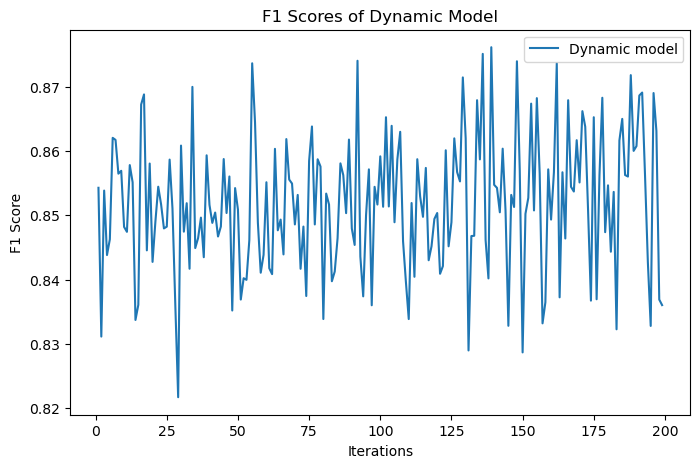

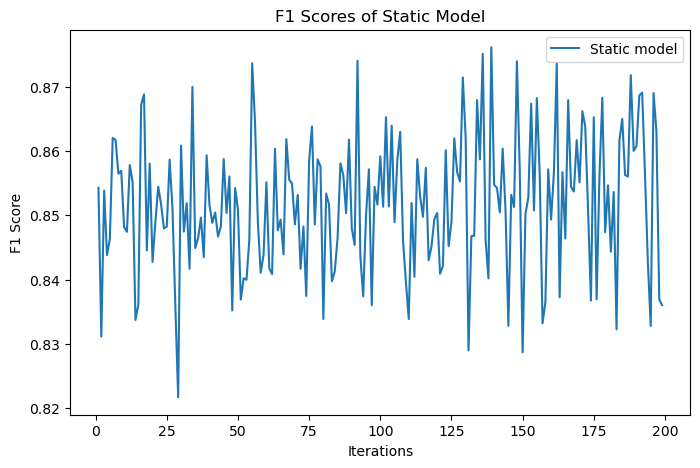

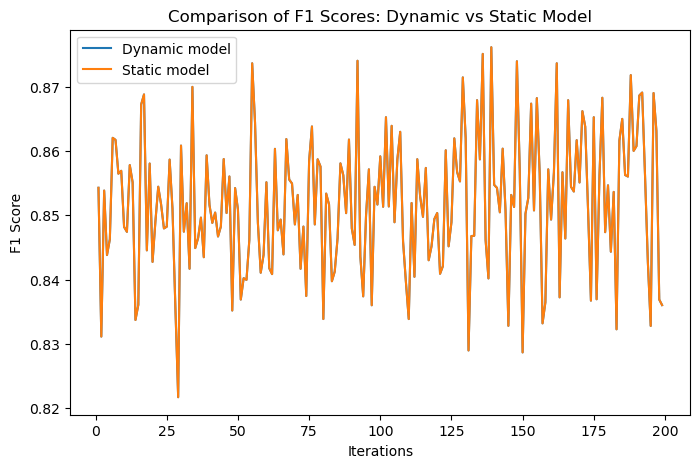

In [17]:
# Plotting F1 scores of the Dynamic model across iterations
plt.figure(figsize=(8, 5))  # Adjusting figure size
plt.plot(range(1, 200), list_of_f1_Dynamic_model, label='Dynamic model')
plt.xlabel('Iterations')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Scores of Dynamic Model')
plt.show()

# Plotting F1 scores of the Static model across iterations
plt.figure(figsize=(8, 5))  # Adjusting figure size
plt.plot(range(1, 200), list_of_f1_static_model, label='Static model')
plt.xlabel('Iterations')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Scores of Static Model')
plt.show()

# Plotting F1 scores of both models on the same plot for comparison
plt.figure(figsize=(8, 5))  # Adjusting figure size
plt.plot(range(1, 200), list_of_f1_Dynamic_model, label='Dynamic model')
plt.plot(range(1, 200), list_of_f1_static_model, label='Static model')
plt.xlabel('Iterations')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Comparison of F1 Scores: Dynamic vs Static Model')
plt.show()
